In [176]:
import pandas as pd
import numpy as np

In [177]:
data = pd.read_csv("Ecommerce Customers.csv")

data_num = data[["Avg. Session Length","Time on App","Time on Website","Length of Membership","Yearly Amount Spent"]]


In [178]:
#data.describe(include='all') #inkludiert auch kategorielle Variabeln 

In [179]:
#data_num.head(5)

In [180]:
#data.isnull().sum() #Überprüfung auf fehlende Werte je Spalte 

Adress analysis

In [181]:
list_shortcut_states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY",]
state_list = []

for i in data["Address"]:
    if "Box" in i:
        index_to_drop = data[data["Address"] == i].index.values 
        data.drop(index_to_drop, inplace = True)
    else:
        state = i.split(",")[-1].split()[0]

        if state in list_shortcut_states:
            state_list.append(state)
        else:
            index_to_drop = data[data["Address"] == i].index.values 
            data.drop(index_to_drop, inplace = True)


data.drop(["Email","Avatar","Address"], inplace = True, axis = 1)
data.insert(5, "State", state_list)

data_mixed = data
data_mixed.index = range(len(data_mixed.index))

#print(data_mixed.head(5))
#print(data_mixed.State.value_counts())

states_and_customers_list = data_mixed.State.value_counts()
#print(type(states_and_customers_list))
print(states_and_customers_list.head(5))

SC    13
MO    13
DE    13
VT    12
OR    12
Name: State, dtype: int64


In [182]:
states = gpd.read_file("cb_2016_us_state_5m\cb_2016_us_state_5m.shp")
#print(states)

In [183]:
for i in states["STUSPS"]:
    if i in states_and_customers_list:
        print(states_and_customers_list[i], i)
    else:
        print("BYE", 0)

9 AL
7 AK
9 AZ
5 CO
5 CT
11 FL
8 GA
3 ID
7 IN
11 KS
6 LA
7 MA
11 MN
13 MO
8 MT
6 NV
10 NJ
8 NY
9 ND
7 OK
8 PA
13 SC
7 SD
8 TX
12 VT
9 WV
BYE 0
6 AR
6 CA
13 DE
BYE 0
9 HI
8 IL
7 IA
8 KY
9 ME
5 MD
9 MI
11 MS
6 NE
7 NH
6 NM
10 NC
5 OH
12 OR
7 RI
5 TN
5 UT
6 VA
4 WA
5 WI
BYE 0
BYE 0
BYE 0
BYE 0
7 WY


<AxesSubplot:>

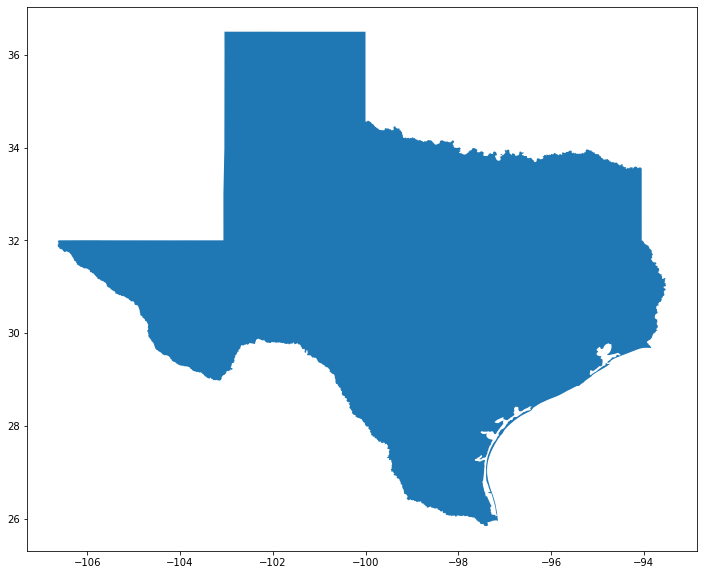

In [184]:
states[states['NAME'] == 'Texas'].plot(figsize=(12, 12))